In [44]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [45]:
df = pd.read_csv('../data/cleaned_heart_disease.csv')

df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,thal,slope_downsloping,slope_flat,slope_upsloping,num
0,0.708333,1,1,0.481132,0.244292,1,2,0.603053,0,2.3,0.0,6.0,1.0,0.0,0.0,0
1,0.791667,1,4,0.622642,0.365297,0,2,0.282443,1,1.5,3.0,3.0,0.0,1.0,0.0,2
2,0.791667,1,4,0.245283,0.235160,0,2,0.442748,1,2.6,2.0,7.0,0.0,1.0,0.0,1
3,0.166667,1,3,0.339623,0.283105,0,0,0.885496,0,3.5,0.0,3.0,1.0,0.0,0.0,0
4,0.250000,0,2,0.339623,0.178082,0,2,0.770992,0,1.4,0.0,3.0,0.0,0.0,1.0,0


In [46]:
x = df.drop('num', axis=1)
y = df['num']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

model_randomforest = RandomForestClassifier(n_estimators=100, random_state=42)

model_randomforest.fit(x_train, y_train)

y_pred = model_randomforest.predict(x_test)

print(r2_score(y_test, y_pred))

0.8255606308389255


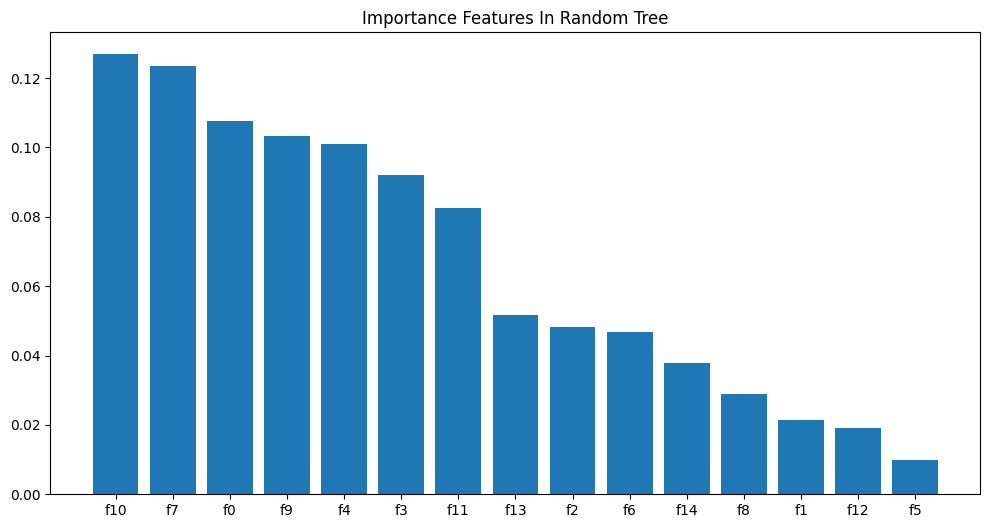

In [47]:
importances = model_randomforest.feature_importances_

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.bar([f'f{i}' for i in indices], importances[indices])
plt.title('Importance Features In Random Tree')
plt.show()

In [48]:
model_xgb = xgb.XGBClassifier()

model_xgb.fit(x_train, y_train)

y_pred = model_xgb.predict(x_test)

print(r2_score(y_test, y_pred))

0.7834545762138386


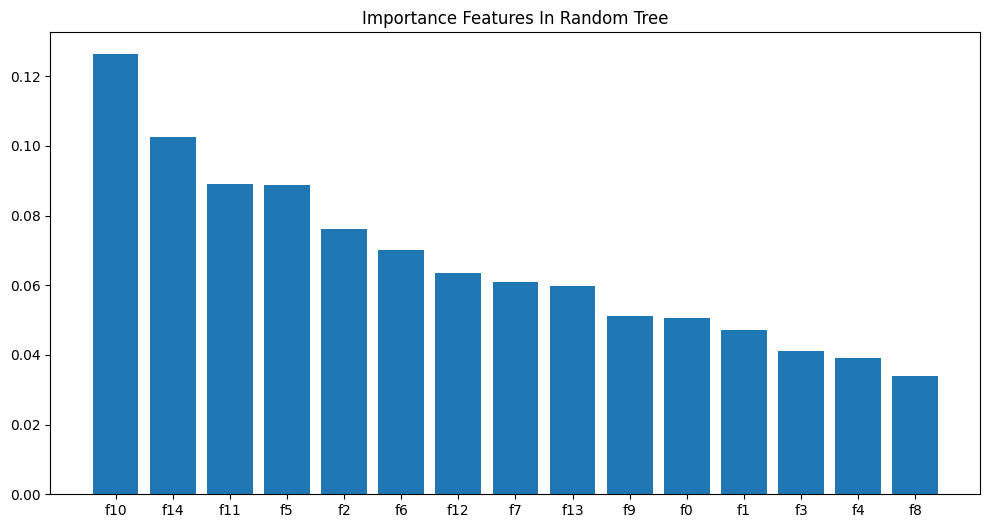

In [49]:
importances = model_xgb.feature_importances_

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.bar([f'f{i}' for i in indices], importances[indices])
plt.title('Importance Features In Random Tree')
plt.show()

In [50]:
selector_randomforest = RFE(model_randomforest, n_features_to_select=6)
selector_xgb = RFE(model_xgb, n_features_to_select=6)

selector_randomforest = selector_randomforest.fit(x_train, y_train)
selector_xgb = selector_xgb.fit(x_train, y_train)

print(f'Best predictors for RandomForestClassifier: {x_train.columns[selector_randomforest.support_]}\n')
print(f'Best predictors for XGBOOST: {x_train.columns[selector_xgb.support_]}')

Best predictors for RandomForestClassifier: Index(['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca'], dtype='object')

Best predictors for XGBOOST: Index(['restecg', 'ca', 'thal', 'slope_downsloping', 'slope_flat',
       'slope_upsloping'],
      dtype='object')


In [51]:
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)

chi2_selector = SelectKBest(score_func=chi2, k=6)
X_kbest = chi2_selector.fit_transform(x_scaled, y)

In [52]:
chi2_scores = chi2_selector.scores_
p_values = chi2_selector.pvalues_

chi2_df = pd.DataFrame({
    "feature": x.columns,
    "chi2 score": chi2_scores,
    "p-value": p_values
}).sort_values(by="chi2 score", ascending=False)

chi2_df.head(10)

,feature,chi2 score,p-value
14,slope_upsloping,134.634594,3.971916e-28
11,thal,76.446040,9.851319e-16
10,ca,69.780947,2.524870e-14
8,exang,49.724638,4.121920e-10
13,slope_flat,43.942136,6.595802e-09
9,oldpeak,32.479968,1.526164e-06
5,fbs,29.703704,5.623448e-06
6,restecg,22.191294,1.835907e-04
12,slope_downsloping,16.697861,2.212419e-03
2,cp,12.516563,1.389622e-02


In [53]:
df = df[['slope_upsloping', 'thal', 'ca', 'exang', 'slope_flat', 'oldpeak', 'num']]

df.to_csv('../data/importance_heart_disease.csv')